In [74]:
### Run MOFA Model on the data generated in the previous script (02)

#############################################
# Prerequisites - Load Libraries

In [75]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/mofa_analysis//lib/R/library"


In [76]:
source('MS1_Functions.r')

In [77]:
source('MS2_Plot_Config.r')

In [78]:
#py_config() # - To check the configuration which python package will be used for MOFA

###############################################
# Preqrequisites Configurations & Parameters

In [79]:
### Load the parameters that are set via the configuration files

In [80]:
### Load configurations file
global_configs = read.csv('configurations/Data_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/Data_Configs.csv'”


In [81]:
head(global_configs,2)

,parameter,value
,<chr>,<chr>
1,data_path,/lustre/groups/epigenereg01/workspace/projects/jove/input_data/
2,result_path,/lustre/groups/epigenereg01/workspace/projects/jove/results/


In [82]:
data_path = global_configs$value[global_configs$parameter == 'data_path']

In [83]:
data_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/input_data/"

In [84]:
result_path = global_configs$value[global_configs$parameter == 'result_path']

In [85]:
result_path

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results/"

In [86]:
## MOFA Model Configurations

In [87]:
mofa_configs = read.csv( 'configurations/03_MOFA_Configs.csv', sep = ',')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'configurations/03_MOFA_Configs.csv'”


In [88]:
head(mofa_configs,2)

,configuration_name,mofa_result_name,amount_of_factors,weighting_of_views,scale_views
,<chr>,<chr>,<int>,<lgl>,<lgl>
1,MI_v1,MI_v1_MOFA,20,FALSE,TRUE
2,MI_v1,MI_v1_MOFA_10,10,FALSE,TRUE


In [89]:
### Generate the result data directory if it does not exist yet
if(!file.exists(paste0(result_path, '03_results'))){
    dir.create(file.path(paste0(result_path, '03_results')))
    }

# Load Data 

## Prepared combined data

In [90]:
### Load the data that was generated in the previous script using the name specified in the configuration file

In [91]:
input_data = list()

In [92]:
for(i in 1:nrow(mofa_configs)){
    path = paste0(result_path, '/02_results/02_Combined_Data_', mofa_configs$configuration_name[i] ,'_INTEGRATED.csv')
    data_long = read.csv(path)
    data_long$X = NULL
    print(path)
    print(file.info(path)$mtime)
    input_data[[i]]= data_long
    }

[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//02_results/02_Combined_Data_MI_v1_INTEGRATED.csv"
[1] "2023-12-20 22:19:38 CET"
[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//02_results/02_Combined_Data_MI_v1_INTEGRATED.csv"
[1] "2023-12-20 22:19:38 CET"
[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//02_results/02_Combined_Data_MI_v1_INTEGRATED.csv"
[1] "2023-12-20 22:19:38 CET"
[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//02_results/02_Combined_Data_MI_v1_INTEGRATED.csv"
[1] "2023-12-20 22:19:38 CET"


In [93]:
length(unique(input_data[[1]]$variable))

[1] 9625

In [94]:
unique(input_data[[1]]$type)

[1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"

In [95]:
length(unique(input_data[[1]]$sample_id))

[1] 128

# Train MOFA Model

## Prepare data list

In [96]:
### Adjust single-cell types to correspond to cell-types

In [97]:
head(input_data[[1]],2)

,sample_id,variable,value,type,gene
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,k10,B.cell__ACTB,0.4307273,B.cell,ACTB
2,k11,B.cell__ACTB,-0.7009514,B.cell,ACTB


In [98]:
### Prepare data list for MOFA (adjust format of input data to be used as input for MOFA)

In [99]:
input_data_list = list()

In [100]:
data_list = list()

In [101]:
input_data_list = lapply(input_data, function(x){

    for(i in unique(x$type)){
        samples = unique(x$sample_id) # necessary to have all samples in all dimensions
        data = x[x$type == i, ]

        data$type = NULL
        data$cell_type = NULL

        data = data %>% dcast(variable ~ sample_id, value  = "value")
        rownames(data) = data$variable
        colnames(data) = str_replace(colnames(data), 'value\\.', '')
        data$variable = NULL

        data[setdiff( samples, names(data))] = NA  # use all samples

        data = data[,order(colnames(data))]
        data = data[,colnames(data) %in% samples]

        data_list[[i]] = as.matrix(data)
        }
    
    return(data_list)
    })

In [102]:
head(input_data_list[[1]][[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
B.cell__ACTB,NA,0.4307273,-0.7009514,0.1151410,-0.2858409,0.6102946,0.3186394,-0.7977768,-0.09413741,-0.09413741,⋯,1.4696127,1.469613,-0.09413741,-1.469613,-1.001331,0.984235,-0.4422154,0.3186394,0.4307273,1.09162
B.cell__ACTG1,NA,1.2815516,-0.2533471,0.0417893,-0.6614351,-1.0728613,0.2858409,-0.4079187,0.40791874,-1.13033917,⋯,0.6876604,0.167894,-0.90273479,-1.605730,-0.512454,-1.731664,-1.9599640,-0.7143674,0.8717710,1.21334


In [103]:
#str(input_data_list)

## Create MOFA object

In [104]:
### Create a MOFA object to run the MOFA model on it

In [105]:
names(input_data_list[[1]])

[1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"

In [106]:
mofa_object = lapply(input_data_list, function(x){
    MOFAobject = create_mofa(x)
    }
                     )

Creating MOFA object from a list of matrices (features as rows, sample as columns)...


Creating MOFA object from a list of matrices (features as rows, sample as columns)...


Creating MOFA object from a list of matrices (features as rows, sample as columns)...


Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [107]:
### Plot the Data Overview showing the input used for the MOFA Model

In [108]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [109]:
# Sizes of the plot
width_par = 5
height_par =5

In [110]:
options(repr.plot.width=30, repr.plot.height=10)

mofa_overview = lapply(mofa_object, function(x){
    mofa_overview = plot_data_overview(x)
    mofa_overview = mofa_overview + plot_config + theme(axis.text.y = element_text(hjust = 0, vjust = 0.5)) +
                xlabel + ylabel + theme(axis.text.x = element_blank())
    })

In [111]:
#mofa_overview[[1]]

In [112]:
# Extract data -type colors (used by the function to align and use those colors in the next plots)
type_colors = list()
for(i in 1:length(mofa_overview)){
    color_extraction =  ggplot_build(mofa_overview[[i]])
    type_colors[[i]] = unique(color_extraction$data[[1]]["fill"][,1])
    type_colors[[i]] = type_colors[[i]][!type_colors[[i]] == 'grey']
    }
    

In [113]:
type_colors

[[1]]
 [1] "#FF7F50" "#D95F02" "#377EB8" "#E6AB02" "#31A354" "#7570B3" "#E7298A"
 [8] "#66A61E" "#A6761D" "#666666" "#E41A1C" "#4DAF4A" "#984EA3" "#FF7F00"
[15] "#FFFF33" "#A65628" "#F781BF"

[[2]]
 [1] "#FF7F50" "#D95F02" "#377EB8" "#E6AB02" "#31A354" "#7570B3" "#E7298A"
 [8] "#66A61E" "#A6761D" "#666666" "#E41A1C" "#4DAF4A" "#984EA3" "#FF7F00"
[15] "#FFFF33" "#A65628" "#F781BF"

[[3]]
 [1] "#FF7F50" "#D95F02" "#377EB8" "#E6AB02" "#31A354" "#7570B3" "#E7298A"
 [8] "#66A61E" "#A6761D" "#666666" "#E41A1C" "#4DAF4A" "#984EA3" "#FF7F00"
[15] "#FFFF33" "#A65628" "#F781BF"

[[4]]
 [1] "#FF7F50" "#D95F02" "#377EB8" "#E6AB02" "#31A354" "#7570B3" "#E7298A"
 [8] "#66A61E" "#A6761D" "#666666" "#E41A1C" "#4DAF4A" "#984EA3" "#FF7F00"
[15] "#FFFF33" "#A65628" "#F781BF"

In [114]:
figure_name = "FIG03_Overview_MOFA_Input_"

In [115]:

for(i in 1:length(mofa_overview)){
    pdf(paste0('figures/03_figures/', figure_name, mofa_configs$mofa_result[i],  '.pdf'), width =width_par, height =height_par)
    print(mofa_overview[[i]] )
    dev.off()
    }

## Set MOFA Training Options and run the Model Training

In [116]:
### Define the MOFA parameters for training and run the model training with the set parameters
### Some parameters are handed over by thhe configuration file
### Others are currently assigned fixed below but can be modified

In [117]:
model_result = list()

In [118]:
for(i in 1:length(mofa_object)){
    
    ## Set other parameters of MOFA Model
    mefisto_opts = get_default_mefisto_options(mofa_object[[i]])
    
    ## Data Options
    data_opts = get_default_data_options(mofa_object[[i]])
    data_opts$scale_views = mofa_configs$scale_views[i] # decide whether to scale the data
    data_opts$use_float32 = FALSE
    print(data_opts)
    
    ## Model Options
    model_opts = get_default_model_options(mofa_object[[i]])
    model_opts$num_factors = mofa_configs$amount_of_factors[i] # define number of factors
    model_opts$spikeslab_weights = TRUE
    # model_opts$likelihoods['neutrophil'] = 'poisson' - example to modify distribution for one specific view
    print(model_opts)
    
    ## Training Options
    train_opts  = get_default_training_options(mofa_object[[i]])
    train_opts$maxiter = 50000
    train_opts$verbose = TRUE
    train_opts$seed = 42
    train_opts$weight_views = mofa_configs$weighting_of_views[i]
    print(train_opts)
    
    ## Build and train the model
    MOFAobject = prepare_mofa(
      object = mofa_object[[i]],
      data_options = data_opts,
      model_options = model_opts,
      mefisto_options = mefisto_opts,
      training_options = train_opts #,
      #stochastic_options = stoch_options
    )
    
    model_name = paste0("03_MOFA_MODEL_", mofa_configs$mofa_result[i], '.hdf5')
    outfile = file.path( paste0(result_path, '/03_results/',  model_name) )
    print(outfile)
    MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)
    

    model_result[[i]] = MOFAobject.trained
    
    }
    

$scale_views
[1] TRUE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"      

$groups
[1] "group1"

$likelihoods
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
        NK  proteomic       Treg 
"gaussian" "gaussian" "gaussian" 

$num_factors
[1] 20

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

$maxiter
[1] 50000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] TRUE

$startELBO


Warning message in prepare_mofa(object = mofa_object[[i]], data_options = data_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//03_results/03_MOFA_MODEL_MI_v1_MOFA.hdf5"



Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 9, 18 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


$scale_views
[1] TRUE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"      

$groups
[1] "group1"

$likelihoods
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
        NK  proteomic       Treg 
"gaussian" "gaussian" "gaussian" 

$num_factors
[1] 10

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

$maxiter
[1] 50000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] TRUE

$startELBO


Warning message in prepare_mofa(object = mofa_object[[i]], data_options = data_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//03_results/03_MOFA_MODEL_MI_v1_MOFA_10.hdf5"


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 6 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


$scale_views
[1] TRUE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"      

$groups
[1] "group1"

$likelihoods
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
        NK  proteomic       Treg 
"gaussian" "gaussian" "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

$maxiter
[1] 50000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] TRUE

$startELBO


Warning message in prepare_mofa(object = mofa_object[[i]], data_options = data_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//03_results/03_MOFA_MODEL_MI_v1_MOFA_15.hdf5"


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 7 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


$scale_views
[1] TRUE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "B.cell"     "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive" 
 [6] "CD4.TCM"    "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"      
[11] "clinical"   "cytokine"   "gdT"        "neutrophil" "NK"        
[16] "proteomic"  "Treg"      

$groups
[1] "group1"

$likelihoods
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
"gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" "gaussian" 
        NK  proteomic       Treg 
"gaussian" "gaussian" "gaussian" 

$num_factors
[1] 25

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

$maxiter
[1] 50000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] TRUE

$startELBO


Warning message in prepare_mofa(object = mofa_object[[i]], data_options = data_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



[1] "/lustre/groups/epigenereg01/workspace/projects/jove/results//03_results/03_MOFA_MODEL_MI_v1_MOFA_25.hdf5"


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 11, 12, 24 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [119]:
#str(model_result)

# Extract and prepare data for plots

In [120]:
### Extract generated data for the model to use for later downstream analysis

## Extract Variance decomposition

In [121]:
# Extract the total explained variance per view and factor

In [122]:
model_result[[1]]@cache[["variance_explained"]]$r2_total  # per view

$group1
    B.cell  CD14.Mono  CD16.Mono    CD4.CTL  CD4.Naive    CD4.TCM    CD4.TEM 
  37.22576   59.37792   36.41470   38.48993   28.12419   60.01864   33.26956 
 CD8.Naive    CD8.TEM       cDC2   clinical   cytokine        gdT neutrophil 
  20.19862   39.45630   27.81158   60.86385   20.88271   49.61847   16.59800 
        NK  proteomic       Treg 
  41.72279   13.36654   30.69905

In [123]:
rowMeans(model_result[[1]]@cache$variance_explained$r2_per_factor[[1]]) # per factor

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7   Factor8 
5.3475420 5.1859179 3.0958451 2.8325997 2.4554561 2.2187481 1.5343117 1.4768466 
  Factor9  Factor10  Factor11  Factor12  Factor13  Factor14  Factor15  Factor16 
1.4278030 1.4192273 1.3989626 1.3855862 1.3467071 0.9860333 0.9425178 0.9209268 
 Factor17  Factor18  Factor19  Factor20 
0.8006671 0.7642000 0.7627576 0.7032589

In [124]:
# Mean total variance explained

In [125]:
mean(model_result[[1]]@cache$variance_explained$r2_total[[1]])

[1] 36.1258

In [126]:
# Save the explained variance

In [127]:
for(i in 1:length(model_result)){
    write.csv(model_result[[i]]@cache$variance_explained$r2_per_factor[[1]], paste0(result_path, '/03_results/03_MOFA_Variance_Decomposition_',mofa_configs$mofa_result[i], '.csv'))
    }
    

## Extract factor and weight data

In [128]:
#### Extract sample factors  values and save

In [129]:
for(i in 1:length(model_result)){
    factors = get_factors(model_result[[i]], factors = "all")
    factors = factors$group1
    head(factors,2)
    
    factors = as.data.frame(factors)
    factors$sample_id = rownames(factors)
    
    # Save as csv
    write.csv(factors, paste0(result_path, '/03_results/03_Factor_Data_' , mofa_configs$mofa_result[i],  '.csv'), row.names = FALSE)
    }

In [130]:
### Extract weight data (feature factor weights) and save

In [131]:
for(j in 1:length(model_result)){
    weights = get_weights(model_result[[j]], views = "all", factors = "all")
    weight_data = data.frame()
    
    for (i in names(weights)){
        data = data.frame(weights[[i]])
        data$type = i
        weight_data = rbind(weight_data,data)
        }
    weight_data$variable_name = rownames(weight_data)
    
    # Save as csv
    write.csv(weight_data, paste0(result_path, '/03_results/03_Weight_Data_' ,mofa_configs$mofa_result[j], '.csv'), row.names = FALSE)
    }
    

# Diagnostic Result Plots

In [132]:
### Make the explained variance plot to analyze the model result

## Plot explained variance overview

In [133]:
## Prepare the data format

In [134]:
explained_variance = lapply(model_result, function(x) {
    data = x@cache$variance_explained$r2_per_factor[[1]]
    data = melt(data)
    
    total_variance = data.frame( view = rownames(x@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = x@cache[["variance_explained"]]$r2_total$group1)
    data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')
    data$Var2 = as.character(data$Var2)
    data$Var2 = factor(data$Var2, levels = sort(unique(data$Var2)))
    data = data[order(data$Var2),]
    }
                            )

In [135]:
#### Plot complete explained variance (Heatmap)

In [136]:
var_decomp = lapply(explained_variance, function(x){
    ggplot() + 
        scale_fill_gradient(low="white", high="black") + 
        xlabel + 
        ylabel +
        plot_config + theme(axis.text.x = element_text(angle = 90), legend.position = 'right')+ 
        geom_tile(data = x, mapping = aes(Var1,  Var2, fill= value))
    })

In [137]:
### Combine the plot with total variance barplot per dimension

In [138]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Explained Variance')

In [139]:
comp_variance = lapply(explained_variance, function(x){
    data = x
    plot_complete = unique(data[,c('Var2', 'total_variance')])
    comp_variance = ggplot(plot_complete, aes(x=Var2, y = total_variance, fill = Var2)) + 
                geom_bar(stat="identity") + coord_flip() + 
                xlabel + 
                ylabel +
                plot_config + scale_fill_manual(values = unlist(type_colors))  ## currently uses same coloring as MOFA oveview
    })

In [140]:
#comp_variance[[1]]

In [141]:
### Combine both visualization

In [142]:
figure_name = "FIG03_Overview_Variance_Decomposition"

In [143]:
# Sizes of the plot
width_par = 8.07
height_par = 4  # 2.8

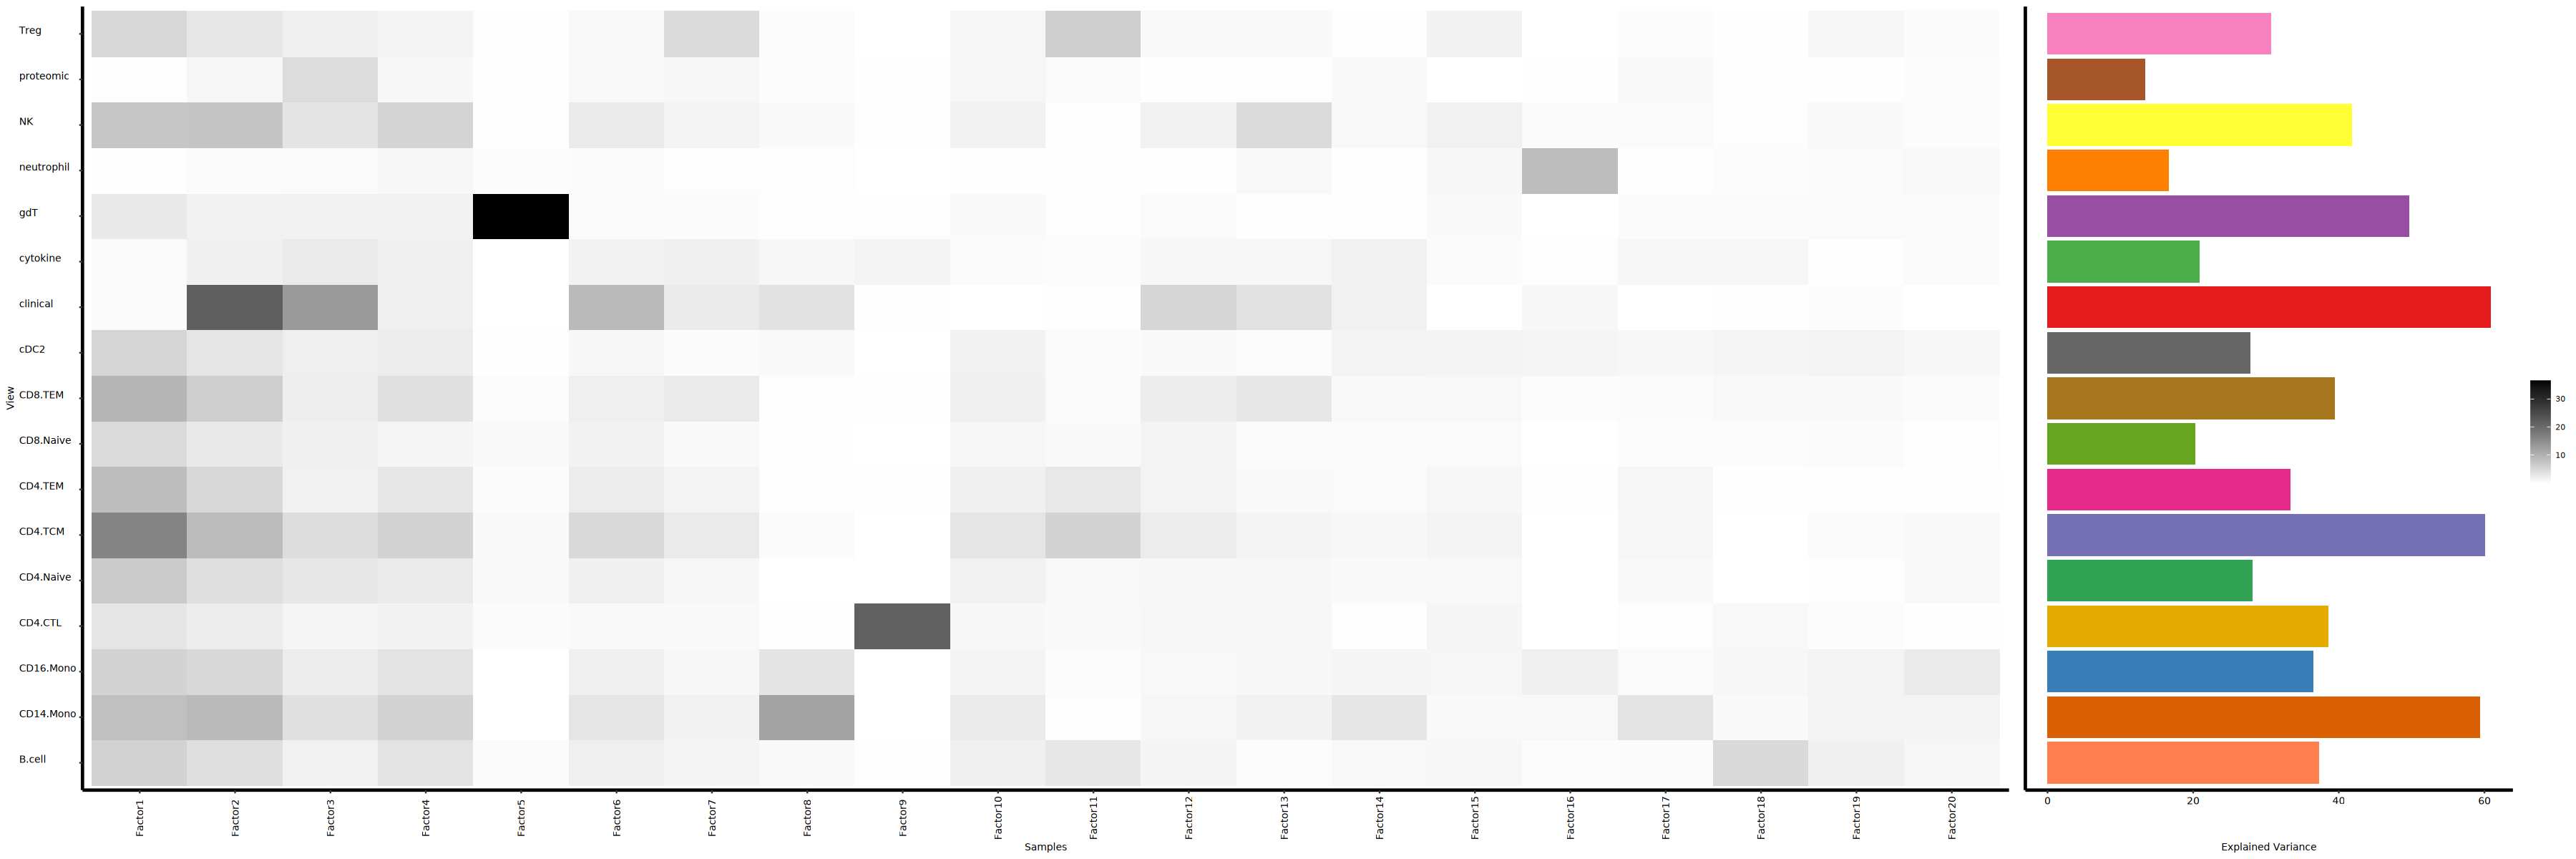

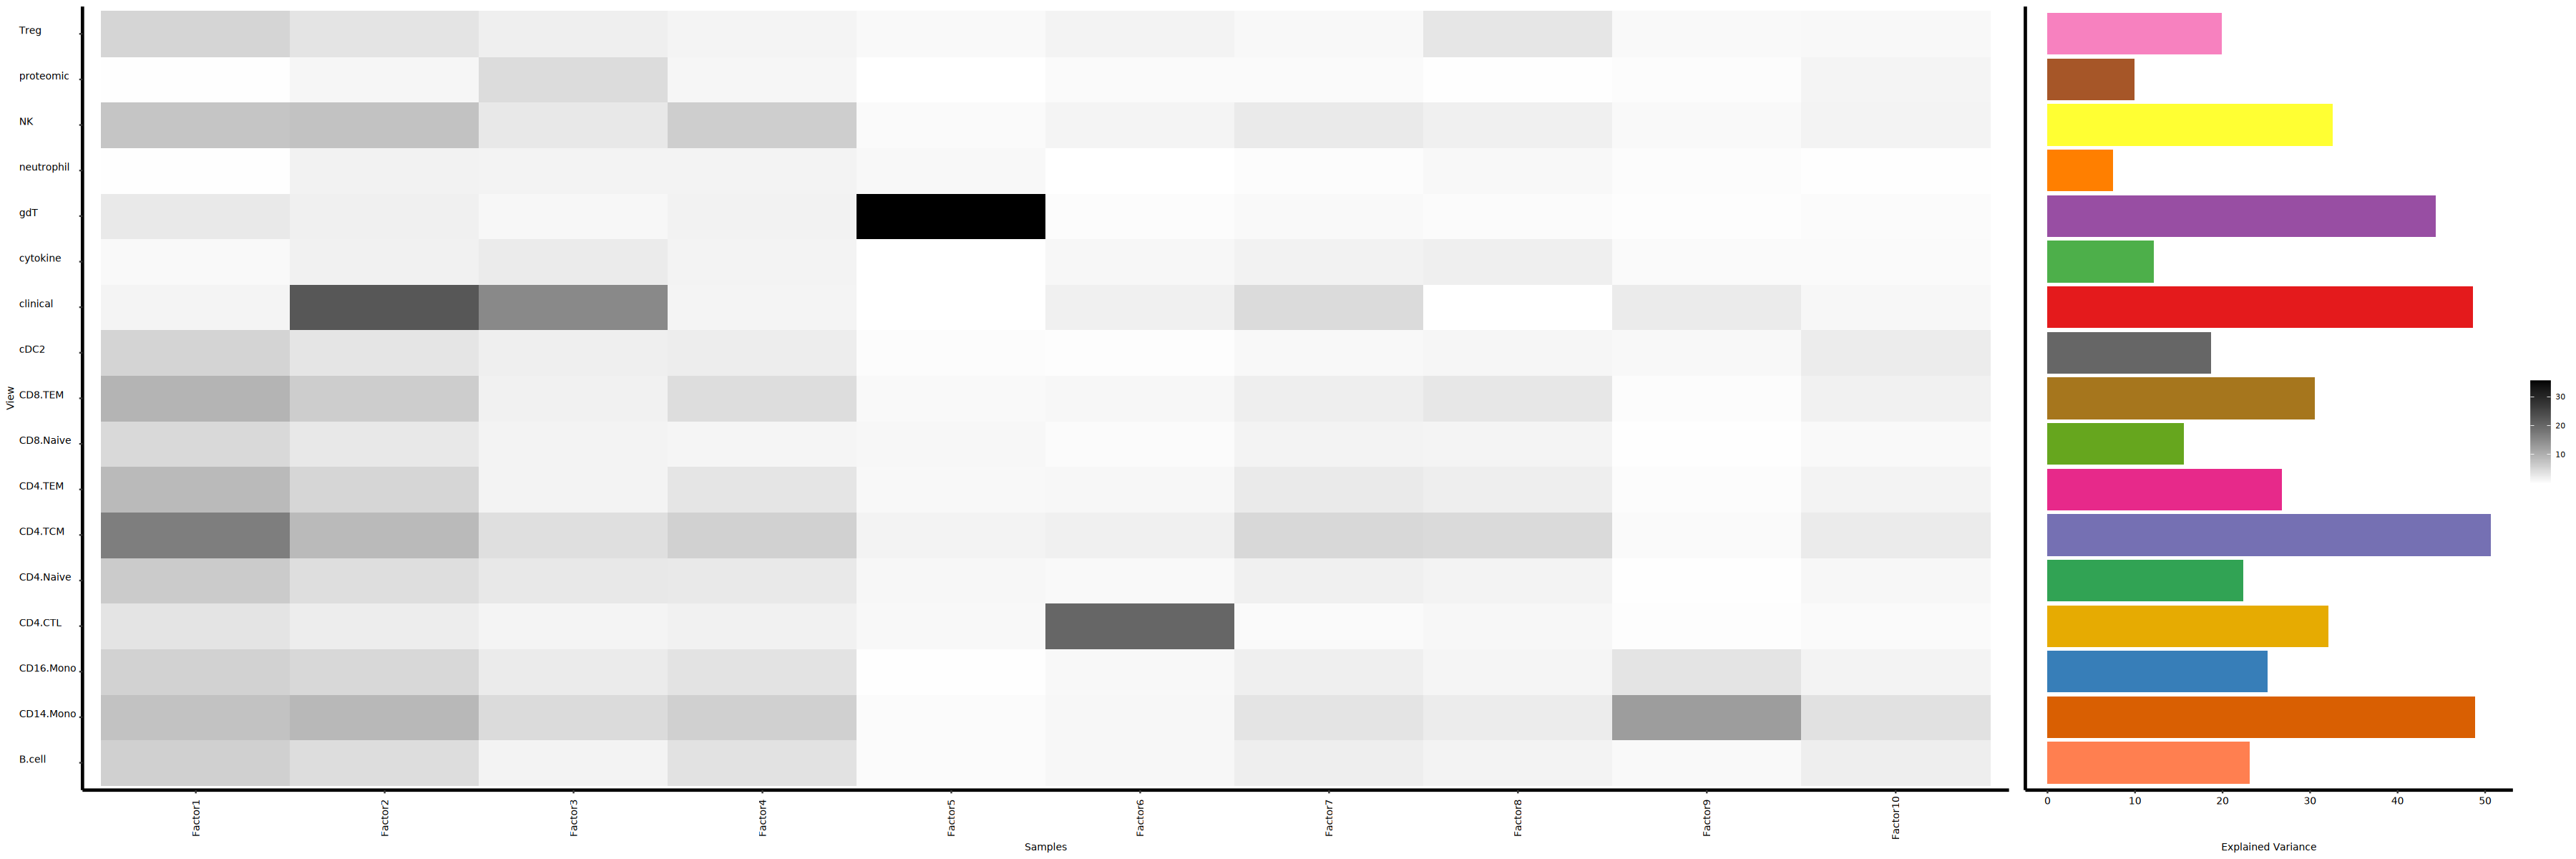

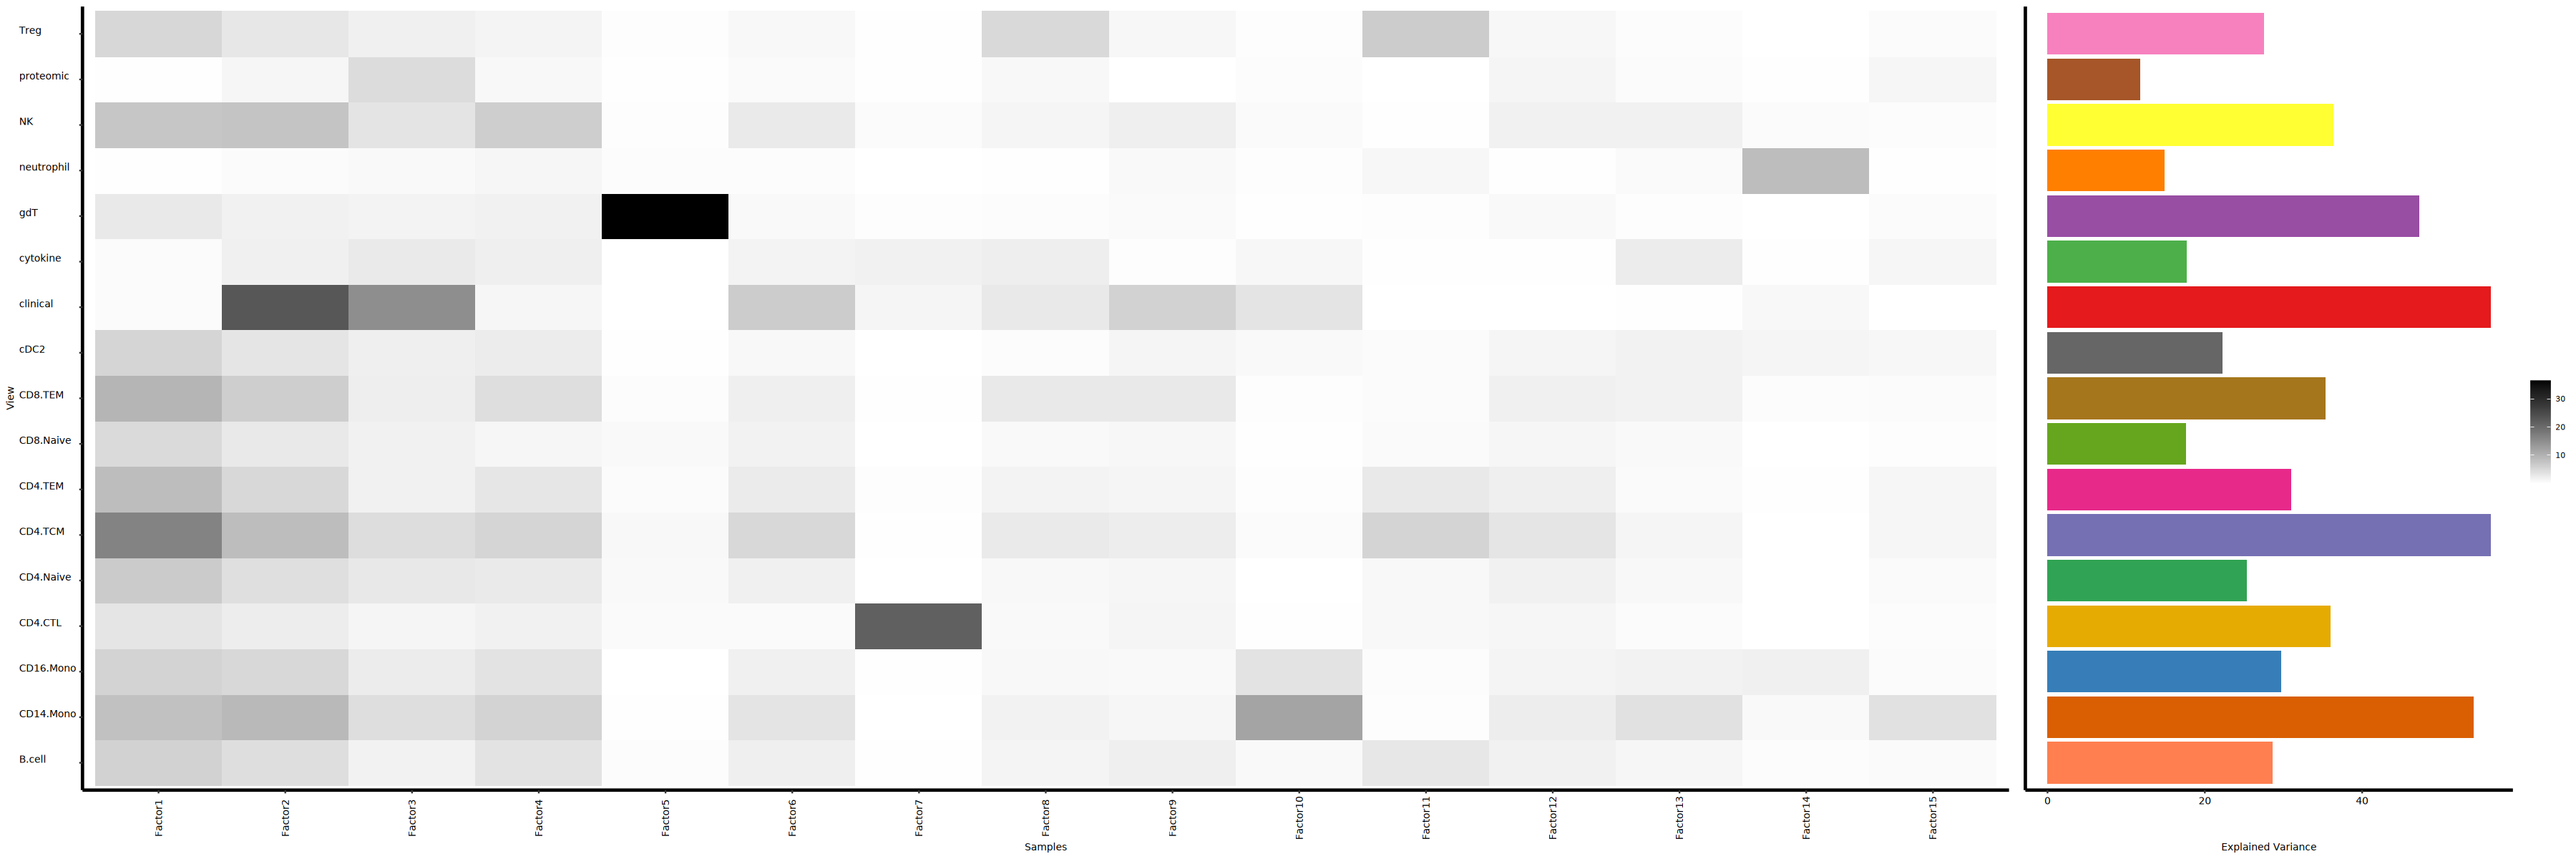

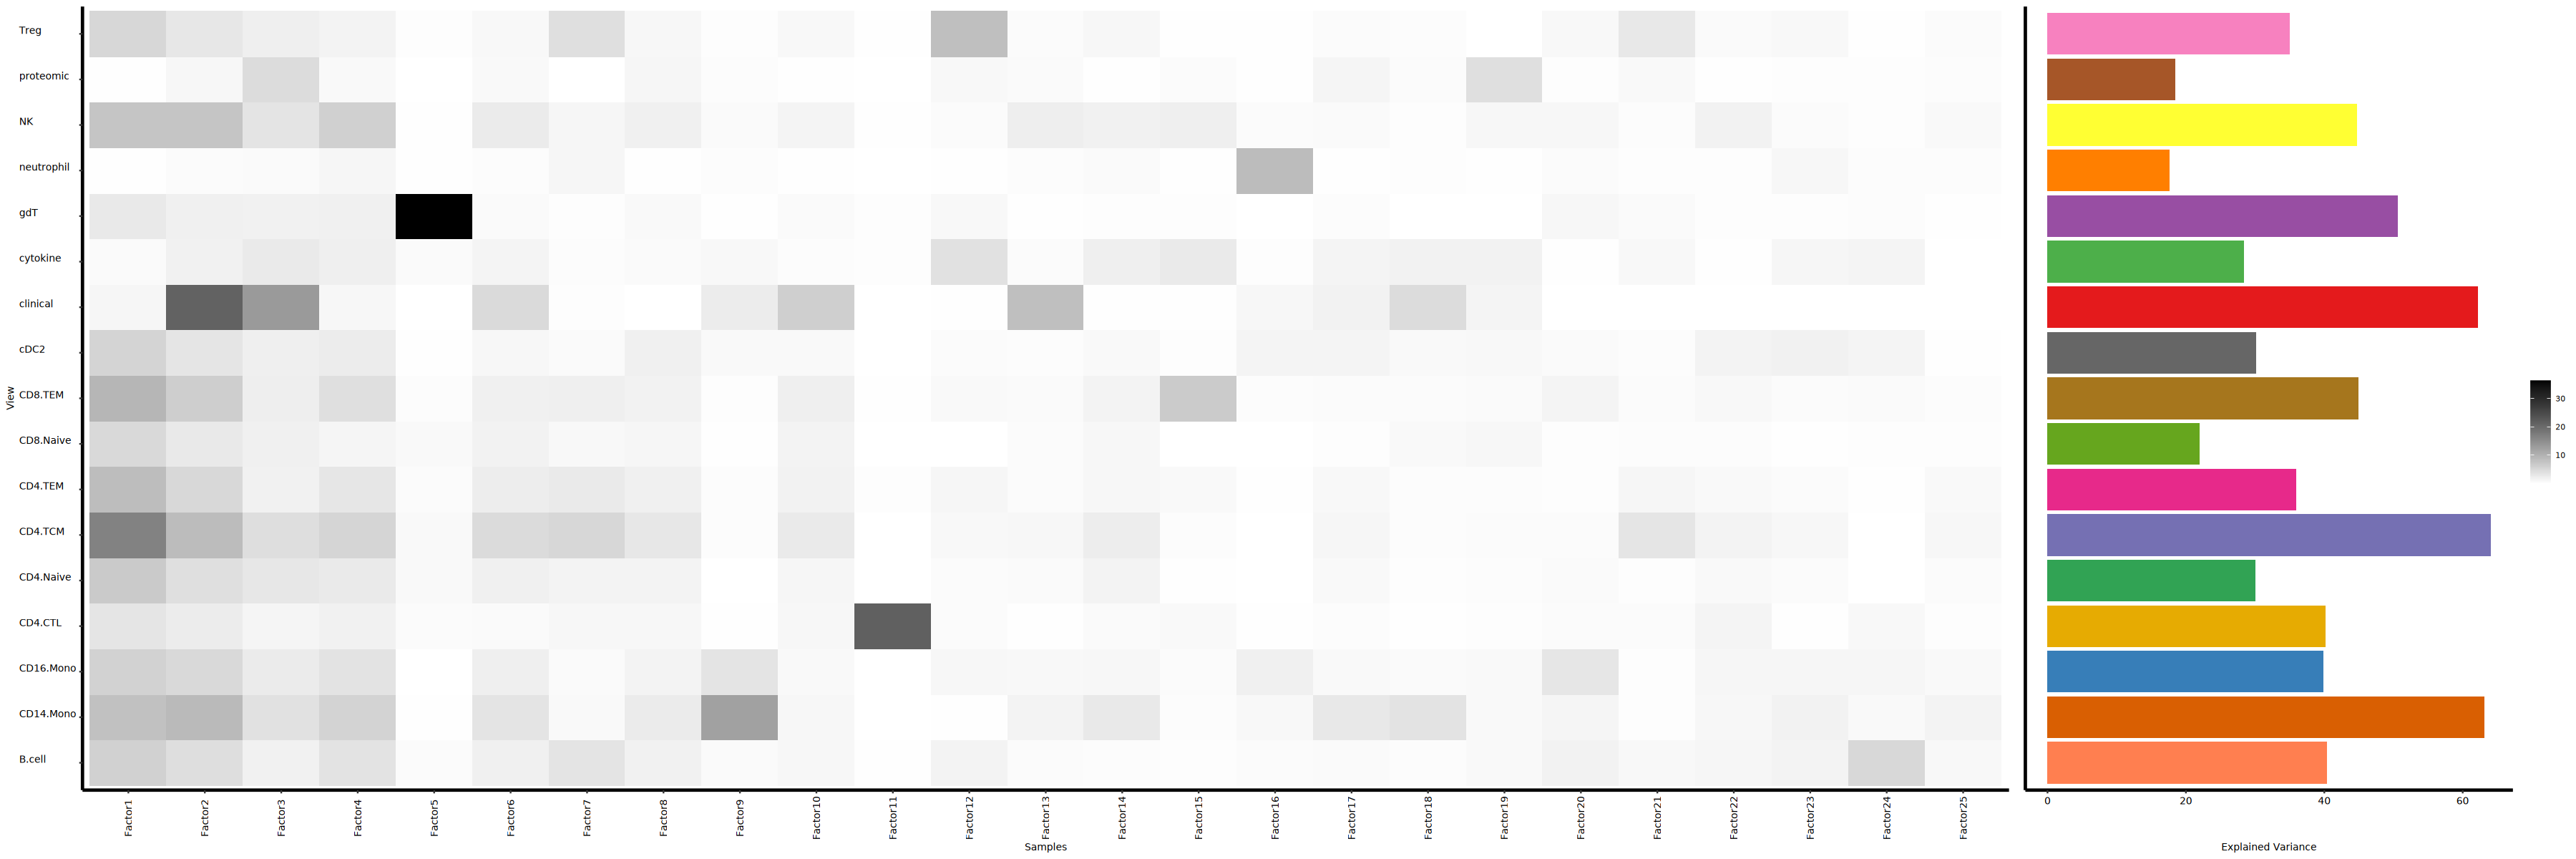

In [144]:
for(i in 1:length(explained_variance)){
    legend = get_legend(var_decomp[[i]])
    
    combination1 = ggarrange(var_decomp[[i]] + theme(legend.position = 'none'),
                     comp_variance[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), legend.position = 'none' ), 
                         align = 'h', nrow=1, widths = c(4,1))
    # Annotate Figure
    combination1_ann = annotate_figure(
      combination1,
      right = legend
    )
    
    pdf(paste0('figures/03_figures/', figure_name,  mofa_configs$mofa_result[i],  '.pdf'), width =width_par, height =height_par)
    print(combination1_ann)
    dev.off()
    print(combination1_ann)
    
    }
    

In [145]:
## Save view colors for further usage

In [146]:
write.csv(data.frame(color_code = unlist(type_colors)),
          paste0('configurations/03_Type_Color_Codes.csv'))